In [1]:
import numpy as np
import pandas as pd
import glob
import errno
import os
import random
import spacy
import string
import pickle as pkl
from collections import Counter

import torch
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
% matplotlib inline

## Load data

In [2]:
train_data_tokens = pkl.load(open("train_data_tokens.p", "rb"))
all_train_tokens = pkl.load(open("all_train_tokens.p", "rb"))

val_data_tokens = pkl.load(open("val_data_tokens.p", "rb"))
test_data_tokens = pkl.load(open("test_data_tokens.p", "rb"))

In [3]:
test_targets = ([1]*12500) + ([0]*12500)
train_split = 10000
train_targets = ([1]*train_split) + ([0]*train_split)
val_targets = ([1]*2500) + ([0]*2500)

In [4]:
len(all_train_tokens)

4814527

In [5]:
token_counter = Counter(all_train_tokens)

In [30]:
sum(sorted(token_counter.values(),reverse=True)[:50000])/sum(token_counter.values())

0.9913947932995287

## Build model

In [7]:
def build_vocab(all_tokens):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

# convert token to id in the dataset
def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

class NewsGroupDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

def newsgroup_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]

class BagOfWords(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(BagOfWords, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim,2)
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
     
        # return logits
        out = self.linear(out.float())
        return out

In [8]:
# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

In [17]:
# save index 0 for pad and 1 for unk
PAD_IDX = 0
UNK_IDX = 1

### tune sgd/adam

In [10]:
max_vocab_size = 10000
MAX_SENTENCE_LENGTH = 200
token2id, id2token = build_vocab(all_train_tokens)

train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)

BATCH_SIZE = 32
train_dataset = NewsGroupDataset(train_data_indices, train_targets)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_targets)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

test_dataset = NewsGroupDataset(test_data_indices, test_targets)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

emb_dim = 100
model = BagOfWords(len(id2token), emb_dim)

In [118]:
learning_rate = 0.01
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

adam_loss = []
adam_train = []
adam_val = []
print('Optimizer: SGD')
for epoch in range(num_epochs):
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 624 == 0:
            # validate
            val_acc = test_model(val_loader, model)
            train_acc = test_model(train_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Train loss: {}, Train acc: {}, Validation Acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), loss, train_acc, val_acc))
            adam_loss.append(loss)
            adam_train.append(train_acc)
            adam_val.append(val_acc)
#     scheduler.step()

Optimizer: Adam
Epoch: [1/10], Step: [625/625], Train loss: 0.18174141645431519, Train acc: 91.44, Validation Acc: 86.12
Epoch: [2/10], Step: [625/625], Train loss: 0.29057276248931885, Train acc: 95.02, Validation Acc: 86.36
Epoch: [3/10], Step: [625/625], Train loss: 0.12753859162330627, Train acc: 96.49, Validation Acc: 85.32
Epoch: [4/10], Step: [625/625], Train loss: 0.18755033612251282, Train acc: 97.765, Validation Acc: 85.22
Epoch: [5/10], Step: [625/625], Train loss: 0.30424365401268005, Train acc: 96.685, Validation Acc: 82.94
Epoch: [6/10], Step: [625/625], Train loss: 0.012027870863676071, Train acc: 97.435, Validation Acc: 83.38
Epoch: [7/10], Step: [625/625], Train loss: 0.01727423258125782, Train acc: 98.97, Validation Acc: 83.74
Epoch: [8/10], Step: [625/625], Train loss: 0.002339296042919159, Train acc: 98.88, Validation Acc: 83.24
Epoch: [9/10], Step: [625/625], Train loss: 0.02233937755227089, Train acc: 99.035, Validation Acc: 82.74
Epoch: [10/10], Step: [625/625], 

In [131]:
learning_rate = 0.01
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

sgd_loss = []
sgd_train = []
sgd_val = []
print('Optimizer: SGD')
for epoch in range(num_epochs):
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 624 == 0:
            # validate
            val_acc = test_model(val_loader, model)
            train_acc = test_model(train_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Train loss: {}, Train acc: {}, Validation Acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), loss, train_acc, val_acc))
            sgd_loss.append(loss)
            sgd_train.append(train_acc)
            sgd_val.append(val_acc)

Optimizer: SGD
Epoch: [1/10], Step: [625/625], Train loss: 0.0047189779579639435, Train acc: 99.675, Validation Acc: 83.18
Epoch: [2/10], Step: [625/625], Train loss: 0.009715398773550987, Train acc: 99.685, Validation Acc: 83.08
Epoch: [3/10], Step: [625/625], Train loss: 0.0029741115868091583, Train acc: 99.69, Validation Acc: 83.08
Epoch: [4/10], Step: [625/625], Train loss: 0.003963891416788101, Train acc: 99.68, Validation Acc: 83.1
Epoch: [5/10], Step: [625/625], Train loss: 0.00460067018866539, Train acc: 99.68, Validation Acc: 83.12
Epoch: [6/10], Step: [625/625], Train loss: 0.021130602806806564, Train acc: 99.68, Validation Acc: 83.1
Epoch: [7/10], Step: [625/625], Train loss: 0.005897659808397293, Train acc: 99.68, Validation Acc: 83.1
Epoch: [8/10], Step: [625/625], Train loss: 0.005139142274856567, Train acc: 99.68, Validation Acc: 83.12
Epoch: [9/10], Step: [625/625], Train loss: 0.004945185035467148, Train acc: 99.695, Validation Acc: 83.12
Epoch: [10/10], Step: [625/625

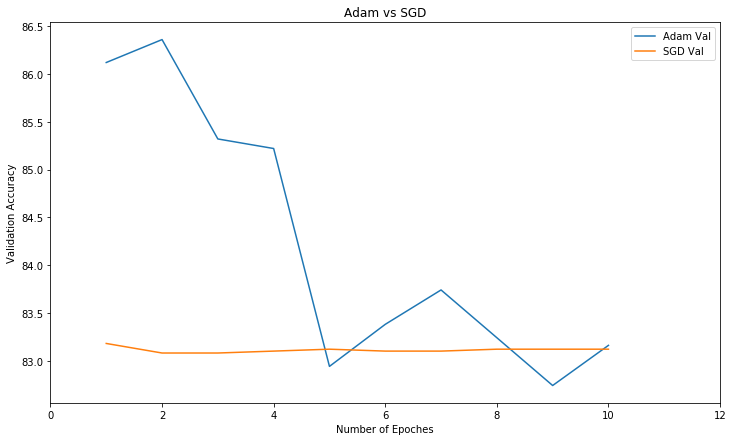

In [132]:
fig = plt.figure(1,figsize = (12,7)) 
ax = plt.subplot(111)
x_rge = list(range(1,11))
plt.plot(x_rge,adam_val,label="Adam Val")
plt.plot(x_rge,sgd_val,label="SGD Val")
# plt.plot(x_rge,adam_loss,label="Train loss")
# plt.plot(random_ridge,label="random at ridge")

# plt.ylim(0,400)
plt.xlim(0,12)
plt.legend(loc=1)
plt.xlabel("Number of Epoches")
plt.ylabel("Validation Accuracy")
plt.title("Adam vs SGD")
plt.show()

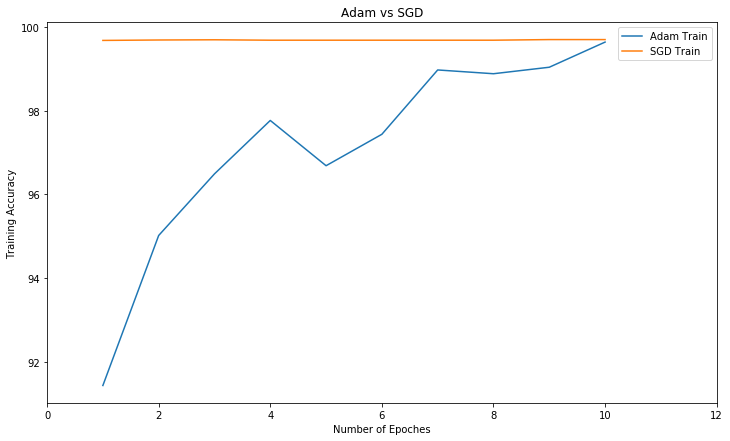

In [133]:
fig = plt.figure(2,figsize = (12,7)) 
ax = plt.subplot(111)
x_rge = list(range(1,11))
plt.plot(x_rge,adam_train,label="Adam Train")
plt.plot(x_rge,sgd_train,label="SGD Train")
# plt.plot(x_rge,adam_loss,label="Train loss")
# plt.plot(random_ridge,label="random at ridge")

plt.xlim(0,12)
plt.legend(loc=1)
plt.xlabel("Number of Epoches")
plt.ylabel("Training Accuracy")
plt.title("Adam vs SGD")
plt.show()

### tune learning rate

In [11]:
lr_list = [0.00001,0.0001,0.0005,0.001,0.005,0.01,0.02]

In [12]:
lr_val_all = []
lr_train_all = []
for i in lr_list:
    learning_rate = i
    num_epochs = 10 # number epoch to train

    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()  
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

    lr_train = []
    lr_val = []
    print('Learning rate: {}'.format(learning_rate))
    for epoch in range(num_epochs):
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()
            # validate every 625 iterations
            if i > 0 and i % 624 == 0:
                # validate
                val_acc = test_model(val_loader, model)
                train_acc = test_model(train_loader, model)
                print('Epoch: [{}/{}], Step: [{}/{}], Train loss: {}, Train acc: {}, Validation Acc: {}'.format( 
                           epoch+1, num_epochs, i+1, len(train_loader), loss, train_acc, val_acc))
#     scheduler.step()
                lr_train.append(train_acc)
                lr_val.append(val_acc)
    lr_train_all.append(lr_train)
    lr_val_all.append(lr_val)

Learning rate: 1e-05
Epoch: [1/10], Step: [625/625], Train loss: 0.7073850035667419, Train acc: 51.37, Validation Acc: 51.26
Epoch: [2/10], Step: [625/625], Train loss: 0.6921596527099609, Train acc: 52.54, Validation Acc: 52.54
Epoch: [3/10], Step: [625/625], Train loss: 0.6879799365997314, Train acc: 53.59, Validation Acc: 53.54
Epoch: [4/10], Step: [625/625], Train loss: 0.6947540044784546, Train acc: 54.895, Validation Acc: 54.48
Epoch: [5/10], Step: [625/625], Train loss: 0.685900866985321, Train acc: 55.975, Validation Acc: 55.62
Epoch: [6/10], Step: [625/625], Train loss: 0.6907626986503601, Train acc: 56.92, Validation Acc: 56.56
Epoch: [7/10], Step: [625/625], Train loss: 0.6839768886566162, Train acc: 58.035, Validation Acc: 57.6
Epoch: [8/10], Step: [625/625], Train loss: 0.6845085620880127, Train acc: 58.73, Validation Acc: 58.36
Epoch: [9/10], Step: [625/625], Train loss: 0.683555006980896, Train acc: 59.36, Validation Acc: 59.04
Epoch: [10/10], Step: [625/625], Train loss

In [14]:
lr_reduce_val = []
lr_reduce_train = []

learning_rate = 0.01
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)


print('Learning rate: {}'.format(learning_rate))
for epoch in range(num_epochs):
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        # validate every 625 iterations
        if i > 0 and i % 624 == 0:
            # validate
            val_acc = test_model(val_loader, model)
            train_acc = test_model(train_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Train loss: {}, Train acc: {}, Validation Acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), loss, train_acc, val_acc))
            lr_reduce_train.append(train_acc)
            lr_reduce_val.append(val_acc)
    scheduler.step()

Learning rate: 0.01
Epoch: [1/10], Step: [625/625], Train loss: 0.015174265950918198, Train acc: 99.98, Validation Acc: 82.44
Epoch: [2/10], Step: [625/625], Train loss: 0.00013396888971328735, Train acc: 99.995, Validation Acc: 82.28
Epoch: [3/10], Step: [625/625], Train loss: 0.0004939436912536621, Train acc: 100.0, Validation Acc: 82.32
Epoch: [4/10], Step: [625/625], Train loss: 0.00024235248565673828, Train acc: 100.0, Validation Acc: 82.22
Epoch: [5/10], Step: [625/625], Train loss: 0.0001216009259223938, Train acc: 100.0, Validation Acc: 82.26
Epoch: [6/10], Step: [625/625], Train loss: 3.0197203159332275e-05, Train acc: 100.0, Validation Acc: 82.26
Epoch: [7/10], Step: [625/625], Train loss: 0.00012637674808502197, Train acc: 100.0, Validation Acc: 82.26
Epoch: [8/10], Step: [625/625], Train loss: 0.0001348555088043213, Train acc: 100.0, Validation Acc: 82.26
Epoch: [9/10], Step: [625/625], Train loss: 2.9578804969787598e-05, Train acc: 100.0, Validation Acc: 82.26
Epoch: [10/1

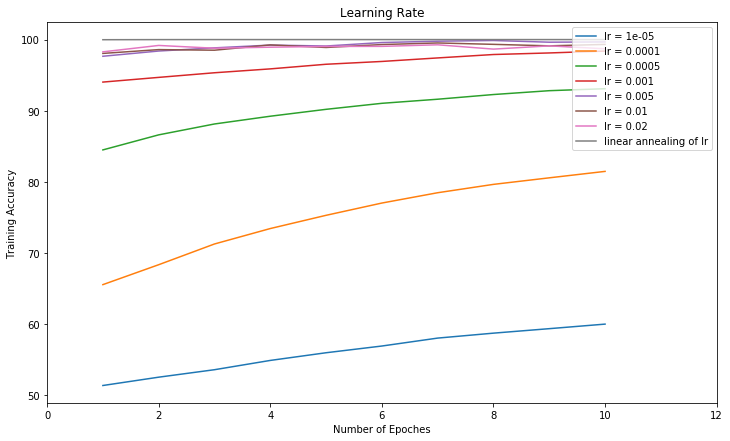

In [15]:
fig = plt.figure(3,figsize = (12,7)) 
ax = plt.subplot(111)
x_rge = list(range(1,11))
for i in range(0,len(lr_train_all)):
    plt.plot(x_rge,lr_train_all[i],label="lr = {}".format(lr_list[i]))
plt.plot(x_rge,lr_reduce_train,label="linear annealing of lr")

plt.xlim(0,12)
plt.legend(loc=1)
plt.xlabel("Number of Epoches")
plt.ylabel("Training Accuracy")
plt.title("Learning Rate")
plt.show()

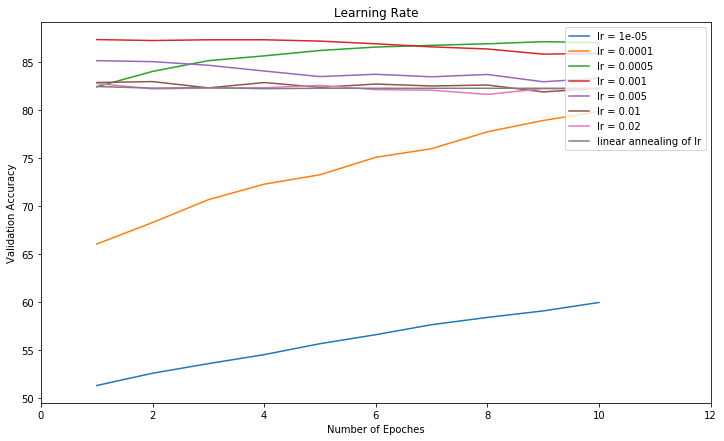

In [16]:
fig = plt.figure(4,figsize = (12,7)) 
ax = plt.subplot(111)
x_rge = list(range(1,11))
for i in range(0,len(lr_val_all)):
    plt.plot(x_rge,lr_val_all[i],label="lr = {}".format(lr_list[i]))
plt.plot(x_rge,lr_reduce_val,label="linear annealing of lr")

plt.xlim(0,12)
plt.legend(loc=1)
plt.xlabel("Number of Epoches")
plt.ylabel("Validation Accuracy")
plt.title("Learning Rate")
plt.show()

Based on validation accuracy, the best result is achieved when lr = 0.001 and after 4 or 5 epoches. Otherwise the training set will overfit the model.

### tune embedding size

In [32]:
embedding_size = [100,200,300,400,500,800,1000]

In [33]:
max_vocab_size = 10000
MAX_SENTENCE_LENGTH = 200
token2id, id2token = build_vocab(all_train_tokens)

train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)

BATCH_SIZE = 32
train_dataset = NewsGroupDataset(train_data_indices, train_targets)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_targets)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

test_dataset = NewsGroupDataset(test_data_indices, test_targets)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

In [34]:
emb_train_all = []
emb_val_all = []
for i in embedding_size:
    emb_dim = i
    
    model = BagOfWords(len(id2token), emb_dim)

    learning_rate = 0.001
    num_epochs = 5 # number epoch to train

    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()  
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    emb_train = []
    emb_val = []
    print('Embedding size: {}'.format(emb_dim))
    for epoch in range(num_epochs):
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and i % 624 == 0:
                # validate
                val_acc = test_model(val_loader, model)
                train_acc = test_model(train_loader, model)
                print('Epoch: [{}/{}], Step: [{}/{}], Train loss: {}, Train acc: {}, Validation Acc: {}'.format( 
                           epoch+1, num_epochs, i+1, len(train_loader), loss, train_acc, val_acc))
                emb_train.append(train_acc)
                emb_val.append(val_acc)
    emb_train_all.append(emb_train)
    emb_val_all.append(emb_val)

Embedding size: 100
Epoch: [1/5], Step: [625/625], Train loss: 0.4980253279209137, Train acc: 81.41, Validation Acc: 79.48
Epoch: [2/5], Step: [625/625], Train loss: 0.29488399624824524, Train acc: 86.79, Validation Acc: 83.8
Epoch: [3/5], Step: [625/625], Train loss: 0.2814379930496216, Train acc: 89.255, Validation Acc: 85.84
Epoch: [4/5], Step: [625/625], Train loss: 0.2199886590242386, Train acc: 90.93, Validation Acc: 86.8
Epoch: [5/5], Step: [625/625], Train loss: 0.3082924485206604, Train acc: 92.255, Validation Acc: 87.2
Embedding size: 200
Epoch: [1/5], Step: [625/625], Train loss: 0.4124726951122284, Train acc: 83.05, Validation Acc: 80.54
Epoch: [2/5], Step: [625/625], Train loss: 0.28532886505126953, Train acc: 88.28, Validation Acc: 84.72
Epoch: [3/5], Step: [625/625], Train loss: 0.25005537271499634, Train acc: 90.805, Validation Acc: 86.36
Epoch: [4/5], Step: [625/625], Train loss: 0.43397819995880127, Train acc: 92.44, Validation Acc: 86.92
Epoch: [5/5], Step: [625/625]

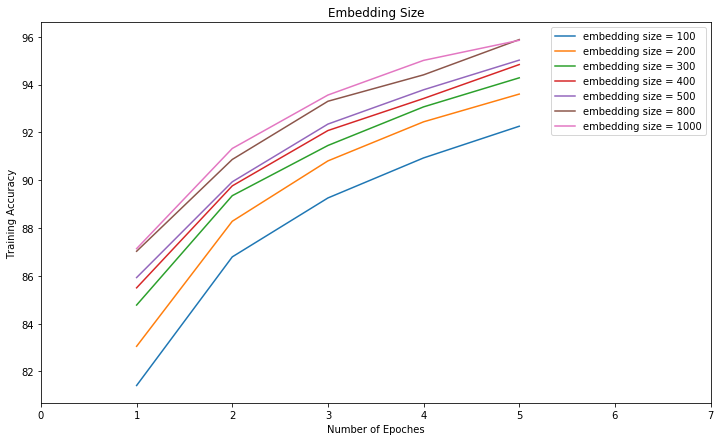

In [36]:
fig = plt.figure(5,figsize = (12,7)) 
ax = plt.subplot(111)
x_rge = list(range(1,6))
for i in range(0,len(emb_train_all)):
    plt.plot(x_rge,emb_train_all[i],label="embedding size = {}".format(embedding_size[i]))

plt.xlim(0,7)
plt.legend(loc=1)
plt.xlabel("Number of Epoches")
plt.ylabel("Training Accuracy")
plt.title("Embedding Size")
plt.show()

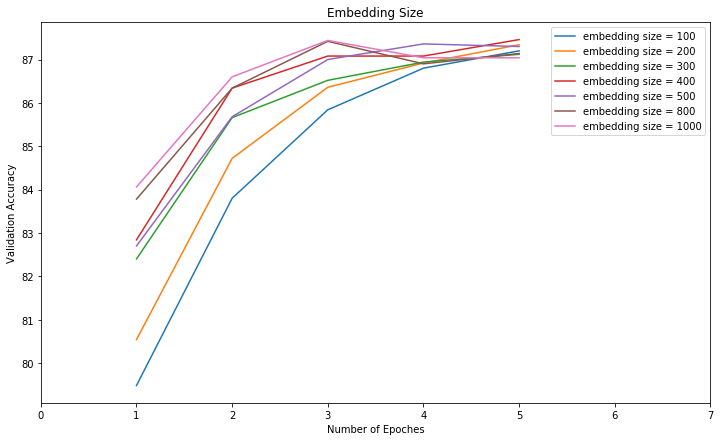

In [37]:
fig = plt.figure(6,figsize = (12,7)) 
ax = plt.subplot(111)
x_rge = list(range(1,6))
for i in range(0,len(emb_val_all)):
    plt.plot(x_rge,emb_val_all[i],label="embedding size = {}".format(embedding_size[i]))

plt.xlim(0,7)
plt.legend(loc=1)
plt.xlabel("Number of Epoches")
plt.ylabel("Validation Accuracy")
plt.title("Embedding Size")
plt.show()

The validation accuracy shows that the best embedding size is 400.

### tune max_sentence_size

In [40]:
max_sentence_size = [200,300,400,500,750,1000]

In [ ]:
max_vocab_size = 10000
token2id, id2token = build_vocab(all_train_tokens)

train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)

In [41]:
msl_train_all = []
msl_val_all = []
for i in max_sentence_size:
    MAX_SENTENCE_LENGTH = i
    
    BATCH_SIZE = 32
    train_dataset = NewsGroupDataset(train_data_indices, train_targets)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=True)

    val_dataset = NewsGroupDataset(val_data_indices, val_targets)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=True)

    test_dataset = NewsGroupDataset(test_data_indices, test_targets)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=False)

    emb_dim = 400
    model = BagOfWords(len(id2token), emb_dim)

    learning_rate = 0.001
    num_epochs = 5 # number epoch to train

    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()  
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    msl_train = []
    msl_val = []
    print('Max sentence length: {}'.format(MAX_SENTENCE_LENGTH))
    for epoch in range(num_epochs):
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and i % 624 == 0:
                # validate
                val_acc = test_model(val_loader, model)
                train_acc = test_model(train_loader, model)
                print('Epoch: [{}/{}], Step: [{}/{}], Train loss: {}, Train acc: {}, Validation Acc: {}'.format( 
                           epoch+1, num_epochs, i+1, len(train_loader), loss, train_acc, val_acc))
                msl_train.append(train_acc)
                msl_val.append(val_acc)
    msl_train_all.append(msl_train)
    msl_val_all.append(msl_val)

Max sentence length: 200
Epoch: [1/5], Step: [625/625], Train loss: 0.39456862211227417, Train acc: 84.71, Validation Acc: 81.92
Epoch: [2/5], Step: [625/625], Train loss: 0.28174787759780884, Train acc: 89.555, Validation Acc: 85.62
Epoch: [3/5], Step: [625/625], Train loss: 0.288017600774765, Train acc: 91.905, Validation Acc: 86.68
Epoch: [4/5], Step: [625/625], Train loss: 0.23553615808486938, Train acc: 93.605, Validation Acc: 87.14
Epoch: [5/5], Step: [625/625], Train loss: 0.1404343545436859, Train acc: 94.83, Validation Acc: 87.34
Max sentence length: 300
Epoch: [1/5], Step: [625/625], Train loss: 0.28705963492393494, Train acc: 86.095, Validation Acc: 84.1
Epoch: [2/5], Step: [625/625], Train loss: 0.1881198137998581, Train acc: 90.49, Validation Acc: 87.14
Epoch: [3/5], Step: [625/625], Train loss: 0.20028457045555115, Train acc: 92.455, Validation Acc: 87.82
Epoch: [4/5], Step: [625/625], Train loss: 0.202487975358963, Train acc: 93.82, Validation Acc: 88.54
Epoch: [5/5], St

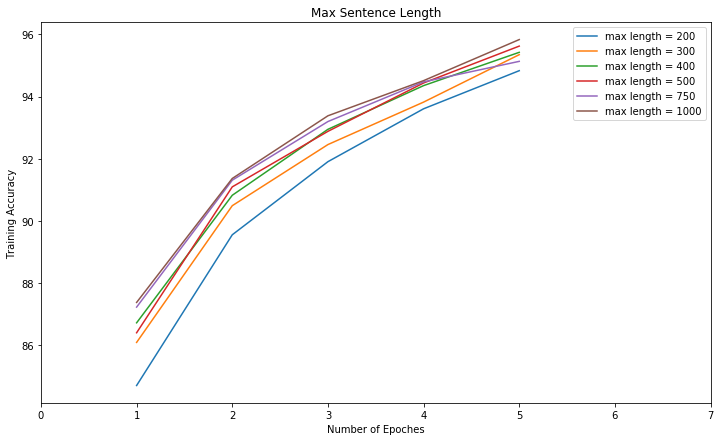

In [42]:
fig = plt.figure(7,figsize = (12,7)) 
ax = plt.subplot(111)
x_rge = list(range(1,6))
for i in range(0,len(msl_train_all)):
    plt.plot(x_rge,msl_train_all[i],label="max length = {}".format(max_sentence_size[i]))

plt.xlim(0,7)
plt.legend(loc=1)
plt.xlabel("Number of Epoches")
plt.ylabel("Training Accuracy")
plt.title("Max Sentence Length")
plt.show()

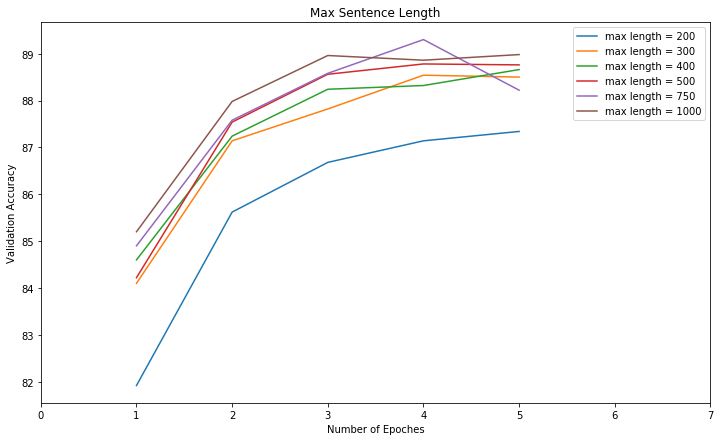

In [43]:
fig = plt.figure(8,figsize = (12,7)) 
ax = plt.subplot(111)
x_rge = list(range(1,6))
for i in range(0,len(msl_val_all)):
    plt.plot(x_rge,msl_val_all[i],label="max length = {}".format(max_sentence_size[i]))

plt.xlim(0,7)
plt.legend(loc=1)
plt.xlabel("Number of Epoches")
plt.ylabel("Validation Accuracy")
plt.title("Max Sentence Length")
plt.show()

best max sentence length is 750

### tune vocab_size

In [44]:
vocab_size_list = [5000,10000,15000,20000,30000,50000]

In [46]:
vocab_train_all = []
vocab_val_all = []
for i in vocab_size_list:
    max_vocab_size = i
    
    MAX_SENTENCE_LENGTH = 750
    token2id, id2token = build_vocab(all_train_tokens)

    train_data_indices = token2index_dataset(train_data_tokens)
    val_data_indices = token2index_dataset(val_data_tokens)
    test_data_indices = token2index_dataset(test_data_tokens)

    BATCH_SIZE = 32
    train_dataset = NewsGroupDataset(train_data_indices, train_targets)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=True)

    val_dataset = NewsGroupDataset(val_data_indices, val_targets)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=True)

    test_dataset = NewsGroupDataset(test_data_indices, test_targets)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=False)

    emb_dim = 400
    model = BagOfWords(len(id2token), emb_dim)

    learning_rate = 0.001
    num_epochs = 5 # number epoch to train

    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()  
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    vocab_train = []
    vocab_val = []
    print('Vocabulary size: {}'.format(max_vocab_size))
    for epoch in range(num_epochs):
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and i % 624 == 0:
                # validate
                val_acc = test_model(val_loader, model)
                train_acc = test_model(train_loader, model)
                print('Epoch: [{}/{}], Step: [{}/{}], Train loss: {}, Train acc: {}, Validation Acc: {}'.format( 
                           epoch+1, num_epochs, i+1, len(train_loader), loss, train_acc, val_acc))
                vocab_train.append(train_acc)
                vocab_val.append(val_acc)
    vocab_train_all.append(vocab_train)
    vocab_val_all.append(vocab_val)

Vocabulary size: 5000
Epoch: [1/5], Step: [625/625], Train loss: 0.41031306982040405, Train acc: 86.12, Validation Acc: 84.2
Epoch: [2/5], Step: [625/625], Train loss: 0.3834429681301117, Train acc: 89.765, Validation Acc: 86.6
Epoch: [3/5], Step: [625/625], Train loss: 0.14295512437820435, Train acc: 91.205, Validation Acc: 87.26
Epoch: [4/5], Step: [625/625], Train loss: 0.20189499855041504, Train acc: 92.365, Validation Acc: 87.86
Epoch: [5/5], Step: [625/625], Train loss: 0.19428861141204834, Train acc: 93.17, Validation Acc: 88.42
Vocabulary size: 10000
Epoch: [1/5], Step: [625/625], Train loss: 0.3454621434211731, Train acc: 86.705, Validation Acc: 84.58
Epoch: [2/5], Step: [625/625], Train loss: 0.1377507895231247, Train acc: 90.89, Validation Acc: 87.78
Epoch: [3/5], Step: [625/625], Train loss: 0.17975570261478424, Train acc: 93.175, Validation Acc: 88.56
Epoch: [4/5], Step: [625/625], Train loss: 0.07496227324008942, Train acc: 94.495, Validation Acc: 88.74
Epoch: [5/5], Step

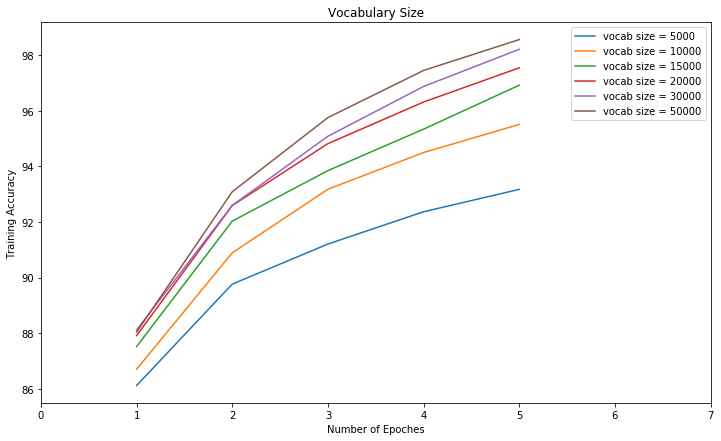

In [47]:
fig = plt.figure(9,figsize = (12,7)) 
ax = plt.subplot(111)
x_rge = list(range(1,6))
for i in range(0,len(vocab_train_all)):
    plt.plot(x_rge,vocab_train_all[i],label="vocab size = {}".format(vocab_size_list[i]))

plt.xlim(0,7)
plt.legend(loc=1)
plt.xlabel("Number of Epoches")
plt.ylabel("Training Accuracy")
plt.title("Vocabulary Size")
plt.show()

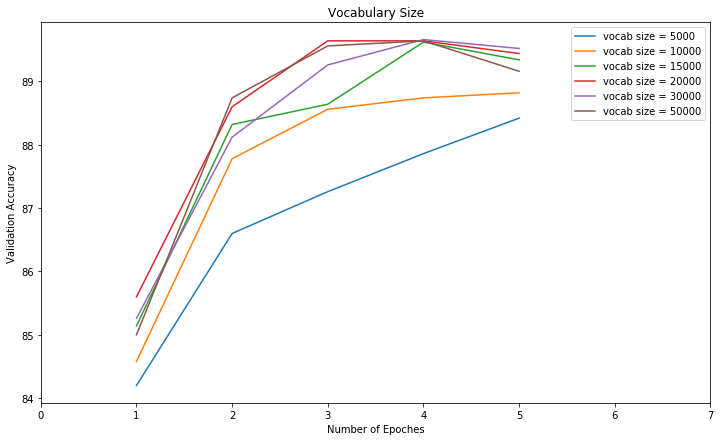

In [48]:
fig = plt.figure(10,figsize = (12,7)) 
ax = plt.subplot(111)
x_rge = list(range(1,6))
for i in range(0,len(vocab_val_all)):
    plt.plot(x_rge,vocab_val_all[i],label="vocab size = {}".format(vocab_size_list[i]))

plt.xlim(0,7)
plt.legend(loc=1)
plt.xlabel("Number of Epoches")
plt.ylabel("Validation Accuracy")
plt.title("Vocabulary Size")
plt.show()

best vocab size: 20000